Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best Params: {'l2_regularization': 0.0, 'learning_rate': 0.05, 'loss': 'poisson', 'max_depth': 6, 'max_iter': 300, 'min_samples_leaf': 10}
Best RMSE (log-space CV): 0.07072079294008606
Daily RMSE: 0.78


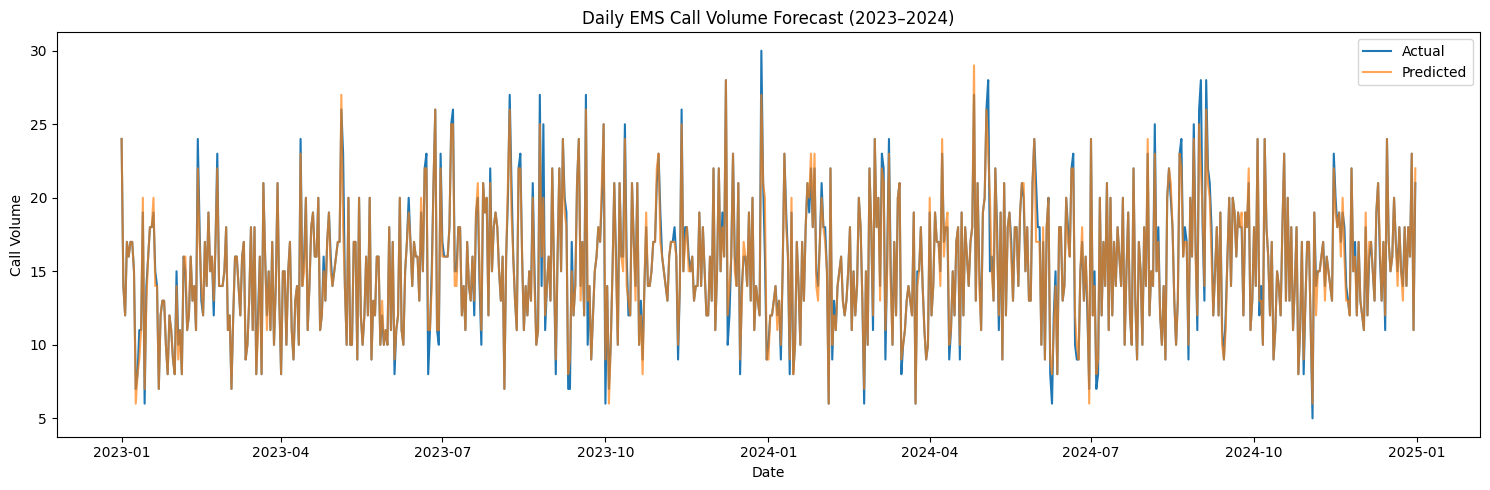

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from pandas.tseries.holiday import USFederalHolidayCalendar
import matplotlib.pyplot as plt

# --- 1. Load and Filter ---
df = pd.read_csv("../data/clean/calls_full.csv")
df['CallDateTime'] = pd.to_datetime(df['CallDateTime'])
df = df[(df['CallDateTime'] >= '2017-01-01') & (df['CallDateTime'] < '2025-01-01')]

# --- 2. Aggregate to Daily ---
df['date'] = df['CallDateTime'].dt.date
daily = df.groupby('date').size().reset_index(name='call_volume')
daily['date'] = pd.to_datetime(daily['date'])

# --- 3. Time Features ---
daily['day_of_week'] = daily['date'].dt.dayofweek
daily['week_of_year'] = daily['date'].dt.isocalendar().week.astype(int)
daily['month'] = daily['date'].dt.month
daily['year'] = daily['date'].dt.year

# --- 4. Lag & Rolling Features (in days) ---
for lag in [1, 2, 7, 14]:
    daily[f'lag_{lag}'] = daily['call_volume'].shift(lag)

daily['rolling_3d'] = daily['call_volume'].rolling(3).mean()
daily['rolling_7d'] = daily['call_volume'].rolling(7).mean()
daily['rolling_30d'] = daily['call_volume'].rolling(30).mean()
daily['same_day_last_week'] = daily['call_volume'].shift(7)

# --- 5. Trend Feature ---
daily['trend_3d'] = daily['rolling_3d'] - daily['rolling_7d']

# --- 6. Holiday & Weekend ---
calendar = USFederalHolidayCalendar()
holidays = calendar.holidays(start=daily['date'].min(), end=daily['date'].max())
daily['is_holiday'] = daily['date'].isin(holidays).astype(int)
daily['is_weekend'] = daily['day_of_week'].isin([5, 6]).astype(int)

# --- 7. Drop NAs ---
daily.dropna(inplace=True)

# --- 8. Feature List ---
features = [
    'day_of_week', 'week_of_year', 'month', 'year',
    'lag_1', 'lag_2', 'lag_7', 'lag_14',
    'rolling_3d', 'rolling_7d', 'rolling_30d',
    'same_day_last_week', 'trend_3d',
    'is_holiday', 'is_weekend'
]

# --- 9. Train/Test Split ---
train = daily[daily['date'] < '2023-01-01']
test = daily[daily['date'] >= '2023-01-01']

X_train = train[features]
X_test = test[features]

# Log-transform target
y_train = np.log1p(train['call_volume'])
y_test = np.log1p(test['call_volume'])

# --- 10. Hyperparameter Tuning ---
param_grid = {
    'max_iter': [200, 300],
    'learning_rate': [0.01, 0.05],
    'max_depth': [6, 10],
    'min_samples_leaf': [10, 20],
    'l2_regularization': [0.0, 0.1],
    'loss': ['poisson']
}

grid = GridSearchCV(
    estimator=HistGradientBoostingRegressor(random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)
print("Best Params:", grid.best_params_)
print("Best RMSE (log-space CV):", -grid.best_score_)

# --- 11. Final Prediction ---
best_model = grid.best_estimator_
preds_log = best_model.predict(X_test)
preds = np.expm1(preds_log).round().astype(int)
y_test_actual = np.expm1(y_test).round().astype(int)

rmse = np.sqrt(mean_squared_error(y_test_actual, preds))
print(f"Daily RMSE: {rmse:.2f}")

# --- 12. Plot ---
plt.figure(figsize=(15, 5))
plt.plot(test['date'], y_test_actual, label='Actual')
plt.plot(test['date'], preds, label='Predicted', alpha=0.7)
plt.legend()
plt.title('Daily EMS Call Volume Forecast (2023–2024)')
plt.xlabel('Date')
plt.ylabel('Call Volume')
plt.tight_layout()
plt.show()


In [2]:
print(f"Average daily call volume (2017–2024): {daily['call_volume'].mean():.2f} calls/day")


Average daily call volume (2017–2024): 14.25 calls/day


Daily RMSE with Fourier Features: 0.80


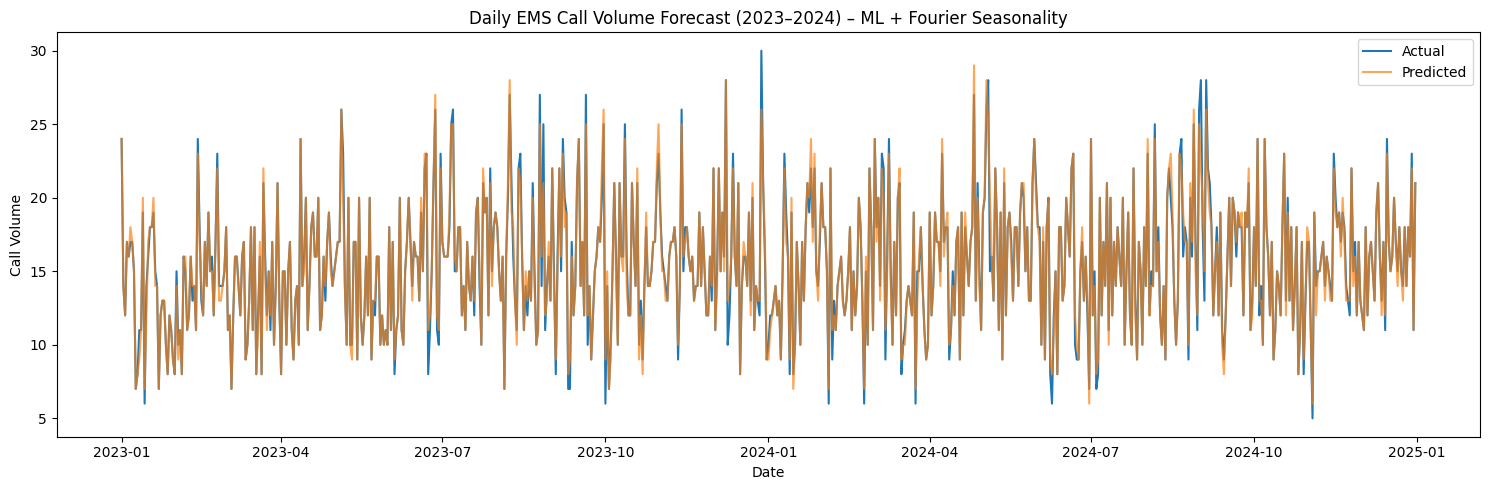

In [4]:
import pandas as pd
import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from pandas.tseries.holiday import USFederalHolidayCalendar
import matplotlib.pyplot as plt

# --- 1. Load & Prepare ---
df = pd.read_csv("../data/clean/calls_full.csv")
df['CallDateTime'] = pd.to_datetime(df['CallDateTime'])
df = df[(df['CallDateTime'] >= '2017-01-01') & (df['CallDateTime'] < '2025-01-01')]
df['date'] = df['CallDateTime'].dt.date
daily = df.groupby('date').size().reset_index(name='call_volume')
daily['date'] = pd.to_datetime(daily['date'])

# --- 2. Time Features ---
daily['day_of_week'] = daily['date'].dt.dayofweek
daily['week_of_year'] = daily['date'].dt.isocalendar().week.astype(int)
daily['month'] = daily['date'].dt.month
daily['year'] = daily['date'].dt.year
daily['day_of_year'] = daily['date'].dt.dayofyear

# --- 3. Fourier Seasonal Terms ---
daily['sin_doy'] = np.sin(2 * np.pi * daily['day_of_year'] / 365.25)
daily['cos_doy'] = np.cos(2 * np.pi * daily['day_of_year'] / 365.25)

# --- 4. Lag & Rolling Features ---
for lag in [1, 2, 7, 14]:
    daily[f'lag_{lag}'] = daily['call_volume'].shift(lag)

daily['rolling_3d'] = daily['call_volume'].rolling(3).mean()
daily['rolling_7d'] = daily['call_volume'].rolling(7).mean()
daily['rolling_30d'] = daily['call_volume'].rolling(30).mean()
daily['same_day_last_week'] = daily['call_volume'].shift(7)
daily['trend_3d'] = daily['rolling_3d'] - daily['rolling_7d']

# --- 5. Holiday/Weekend ---
calendar = USFederalHolidayCalendar()
holidays = calendar.holidays(start=daily['date'].min(), end=daily['date'].max())
daily['is_holiday'] = daily['date'].isin(holidays).astype(int)
daily['is_weekend'] = daily['day_of_week'].isin([5, 6]).astype(int)

# --- 6. Clean Up ---
daily.dropna(inplace=True)

# --- 7. Features ---
features = [
    'day_of_week', 'week_of_year', 'month', 'year',
    'lag_1', 'lag_2', 'lag_7', 'lag_14',
    'rolling_3d', 'rolling_7d', 'rolling_30d',
    'same_day_last_week', 'trend_3d',
    'is_holiday', 'is_weekend',
    'sin_doy', 'cos_doy'
]

# --- 8. Train/Test Split ---
train = daily[daily['date'] < '2023-01-01']
test = daily[daily['date'] >= '2023-01-01']

X_train = train[features]
X_test = test[features]

# Log-transform target
y_train = np.log1p(train['call_volume'])
y_test = np.log1p(test['call_volume'])

# --- 9. Model Training (with optional tuning grid) ---
model = HistGradientBoostingRegressor(
    loss='poisson',
    max_iter=300,
    learning_rate=0.05,
    max_depth=10,
    min_samples_leaf=20,
    random_state=42
)

model.fit(X_train, y_train)

# --- 10. Predict & Evaluate ---
preds_log = model.predict(X_test)
preds = np.expm1(preds_log).round().astype(int)
y_test_actual = np.expm1(y_test).round().astype(int)

rmse = np.sqrt(mean_squared_error(y_test_actual, preds))
print(f"Daily RMSE with Fourier Features: {rmse:.2f}")

# --- 11. Plot ---
plt.figure(figsize=(15, 5))
plt.plot(test['date'], y_test_actual, label='Actual')
plt.plot(test['date'], preds, label='Predicted', alpha=0.7)
plt.legend()
plt.title('Daily EMS Call Volume Forecast (2023–2024) – ML + Fourier Seasonality')
plt.xlabel('Date')
plt.ylabel('Call Volume')
plt.tight_layout()
plt.show()


Daily MLP RMSE: 3.97


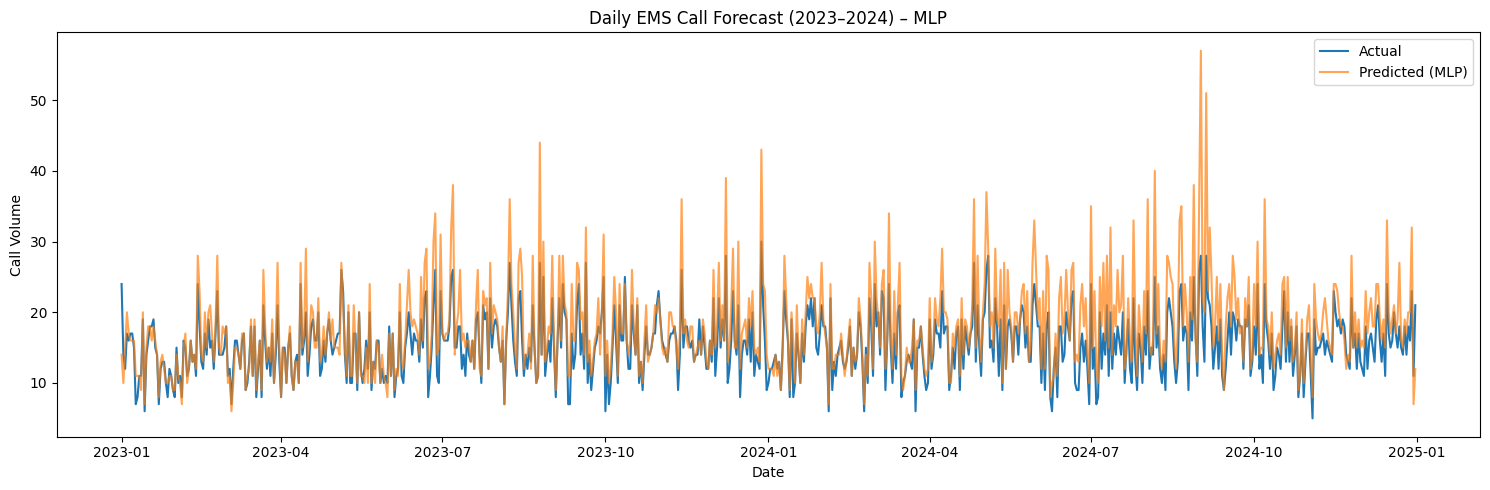

In [5]:
import pandas as pd
import numpy as np
import requests
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from pandas.tseries.holiday import USFederalHolidayCalendar
import matplotlib.pyplot as plt

# --- 1. Load EMS Call Data ---
df = pd.read_csv("../data/clean/calls_full.csv")
df['CallDateTime'] = pd.to_datetime(df['CallDateTime'])
df = df[(df['CallDateTime'] >= '2017-01-01') & (df['CallDateTime'] < '2025-01-01')]
df['date'] = df['CallDateTime'].dt.date
daily = df.groupby('date').size().reset_index(name='call_volume')
daily['date'] = pd.to_datetime(daily['date'])

# --- 2. Calendar Features ---
daily['day_of_week'] = daily['date'].dt.dayofweek
daily['week_of_year'] = daily['date'].dt.isocalendar().week.astype(int)
daily['month'] = daily['date'].dt.month
daily['year'] = daily['date'].dt.year
daily['day_of_year'] = daily['date'].dt.dayofyear
daily['sin_doy'] = np.sin(2 * np.pi * daily['day_of_year'] / 365.25)
daily['cos_doy'] = np.cos(2 * np.pi * daily['day_of_year'] / 365.25)

# --- 3. Lag Features ---
for lag in [1, 2, 3, 7, 14]:
    daily[f'lag_{lag}'] = daily['call_volume'].shift(lag)

daily['rolling_3d'] = daily['call_volume'].rolling(3).mean()
daily['rolling_7d'] = daily['call_volume'].rolling(7).mean()
daily['rolling_30d'] = daily['call_volume'].rolling(30).mean()
daily['same_day_last_week'] = daily['call_volume'].shift(7)
daily['trend_3d'] = daily['rolling_3d'] - daily['rolling_7d']

# Holiday/weekend flags
calendar = USFederalHolidayCalendar()
holidays = calendar.holidays(start=daily['date'].min(), end=daily['date'].max())
daily['is_holiday'] = daily['date'].isin(holidays).astype(int)
daily['is_weekend'] = daily['day_of_week'].isin([5, 6]).astype(int)

# --- 4. Drop missing ---
daily.dropna(inplace=True)

# --- 5. Features ---
features = [
    'day_of_week', 'week_of_year', 'month', 'year',
    'lag_1', 'lag_2', 'lag_3', 'lag_7', 'lag_14',
    'rolling_3d', 'rolling_7d', 'rolling_30d',
    'same_day_last_week', 'trend_3d',
    'is_holiday', 'is_weekend',
    'sin_doy', 'cos_doy'
]

# --- 6. Train/Test Split ---
train = daily[daily['date'] < '2023-01-01']
test = daily[daily['date'] >= '2023-01-01']

X_train = train[features]
X_test = test[features]

# Scale input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Log-transform the target
y_train = np.log1p(train['call_volume'])
y_test = np.log1p(test['call_volume'])

# --- 7. MLP Training ---
mlp = MLPRegressor(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    solver='adam',
    alpha=0.001,
    max_iter=500,
    random_state=42
)
mlp.fit(X_train_scaled, y_train)

# --- 8. Predict & Evaluate ---
preds_log = mlp.predict(X_test_scaled)
preds = np.expm1(preds_log).round().astype(int)
y_test_actual = np.expm1(y_test).round().astype(int)

rmse = np.sqrt(mean_squared_error(y_test_actual, preds))
print(f"Daily MLP RMSE: {rmse:.2f}")

# --- 9. Plot Results ---
plt.figure(figsize=(15, 5))
plt.plot(test['date'], y_test_actual, label='Actual')
plt.plot(test['date'], preds, label='Predicted (MLP)', alpha=0.7)
plt.legend()
plt.title('Daily EMS Call Forecast (2023–2024) – MLP')
plt.xlabel('Date')
plt.ylabel('Call Volume')
plt.tight_layout()
plt.show()


Iteration 1, loss = 0.49468889
Validation score: -26.569908
Iteration 2, loss = 0.11930154
Validation score: -26.455455
Iteration 3, loss = 0.06133392
Validation score: -12.015651
Iteration 4, loss = 0.04040655
Validation score: -10.245426
Iteration 5, loss = 0.02723392
Validation score: -5.496454
Iteration 6, loss = 0.02200105
Validation score: -4.160634
Iteration 7, loss = 0.01704497
Validation score: -3.584113
Iteration 8, loss = 0.01390152
Validation score: -2.591175
Iteration 9, loss = 0.01159724
Validation score: -2.090849
Iteration 10, loss = 0.00981290
Validation score: -1.787111
Iteration 11, loss = 0.00836289
Validation score: -1.429680
Iteration 12, loss = 0.00728301
Validation score: -1.165958
Iteration 13, loss = 0.00641547
Validation score: -0.998574
Iteration 14, loss = 0.00568918
Validation score: -0.793658
Iteration 15, loss = 0.00510191
Validation score: -0.672901
Iteration 16, loss = 0.00461500
Validation score: -0.560446
Iteration 17, loss = 0.00422305
Validation sc

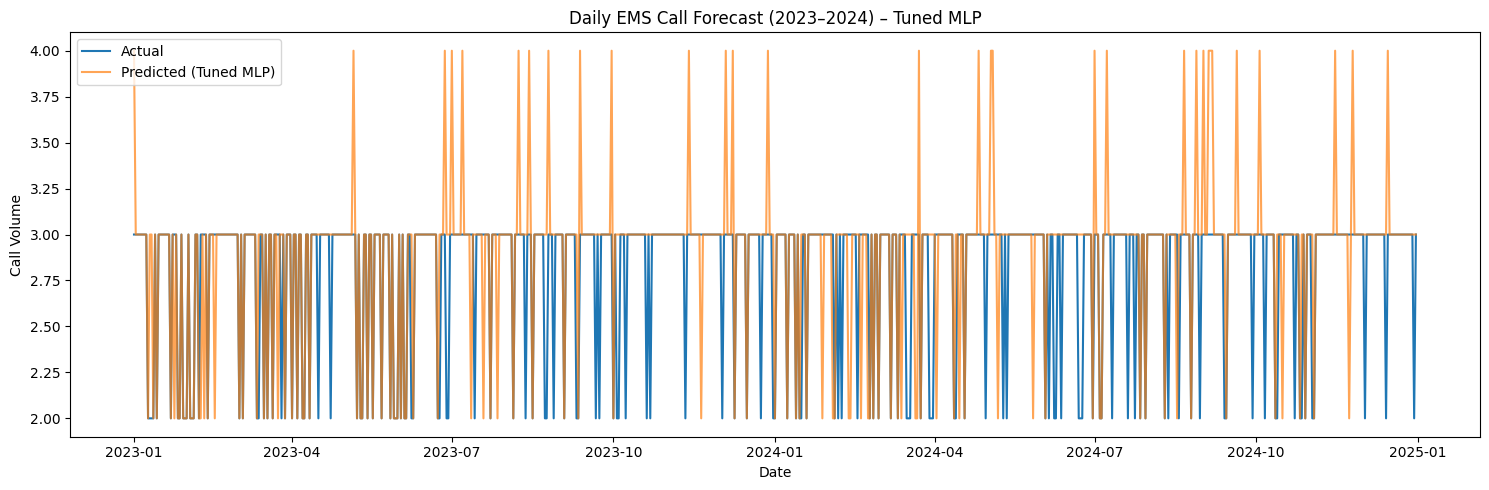

In [6]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# --- Scale Inputs ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Log-transform target ---
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# --- Train MLP ---
mlp = MLPRegressor(
    hidden_layer_sizes=(128, 64),
    activation='relu',
    solver='adam',
    alpha=0.0005,
    learning_rate_init=0.001,
    max_iter=2000,
    early_stopping=True,
    n_iter_no_change=20,
    validation_fraction=0.1,
    random_state=42,
    verbose=True
)

mlp.fit(X_train_scaled, y_train_log)

# --- Predict and Evaluate ---
preds_log = mlp.predict(X_test_scaled)
preds = np.expm1(preds_log).round().astype(int)
y_test_actual = np.expm1(y_test_log).round().astype(int)

rmse = np.sqrt(mean_squared_error(y_test_actual, preds))
print(f"Tuned MLP Daily RMSE: {rmse:.2f}")

# --- Plot ---
plt.figure(figsize=(15, 5))
plt.plot(test['date'], y_test_actual, label='Actual')
plt.plot(test['date'], preds, label='Predicted (Tuned MLP)', alpha=0.7)
plt.legend()
plt.title('Daily EMS Call Forecast (2023–2024) – Tuned MLP')
plt.xlabel('Date')
plt.ylabel('Call Volume')
plt.tight_layout()
plt.show()

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor

param_grid = {
    'hidden_layer_sizes': [(128, 64), (128, 64, 32), (256, 128), (256, 128, 64)],
    'alpha': [0.0001, 0.0005, 0.001],
    'learning_rate_init': [0.0005, 0.001],
}

mlp_base = MLPRegressor(
    activation='relu',
    solver='adam',
    early_stopping=True,
    max_iter=2000,
    n_iter_no_change=20,
    validation_fraction=0.1,
    random_state=42
)

grid = GridSearchCV(
    estimator=mlp_base,
    param_grid=param_grid,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train_scaled, y_train_log)

print("Best Params:", grid.best_params_)
print("Best RMSE (log-space):", -grid.best_score_)

# Final prediction with best model
best_mlp = grid.best_estimator_
preds_log = best_mlp.predict(X_test_scaled)
preds = np.expm1(preds_log).round().astype(int)
y_test_actual = np.expm1(y_test_log).round().astype(int)

rmse = np.sqrt(mean_squared_error(y_test_actual, preds))
print(f"Tuned MLP (Grid Search) RMSE: {rmse:.2f}")


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Params: {'alpha': 0.001, 'hidden_layer_sizes': (128, 64, 32), 'learning_rate_init': 0.001}
Best RMSE (log-space): 0.03205496116611239
Tuned MLP (Grid Search) RMSE: 0.36


Epoch 1/300


/Users/sebastiancondyles/IdeaProjects/AdvAlgoHW4_1/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.1530 - root_mean_squared_error: 2.2212 - val_loss: 0.3264 - val_root_mean_squared_error: 0.5713
Epoch 2/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4838 - root_mean_squared_error: 0.6950 - val_loss: 0.0905 - val_root_mean_squared_error: 0.3009
Epoch 3/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3334 - root_mean_squared_error: 0.5769 - val_loss: 0.0347 - val_root_mean_squared_error: 0.1862
Epoch 4/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2703 - root_mean_squared_error: 0.5197 - val_loss: 0.0583 - val_root_mean_squared_error: 0.2414
Epoch 5/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2291 - root_mean_squared_error: 0.4784 - val_loss: 0.1404 - val_root_mean_squared_error: 0.3747
Epoch 6/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2108 - root_mean_squared_error: 0.4586 - val_loss: 0.1297 - val_root_mean_squared_error: 0.3601
Epoch 7/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1944 - ro

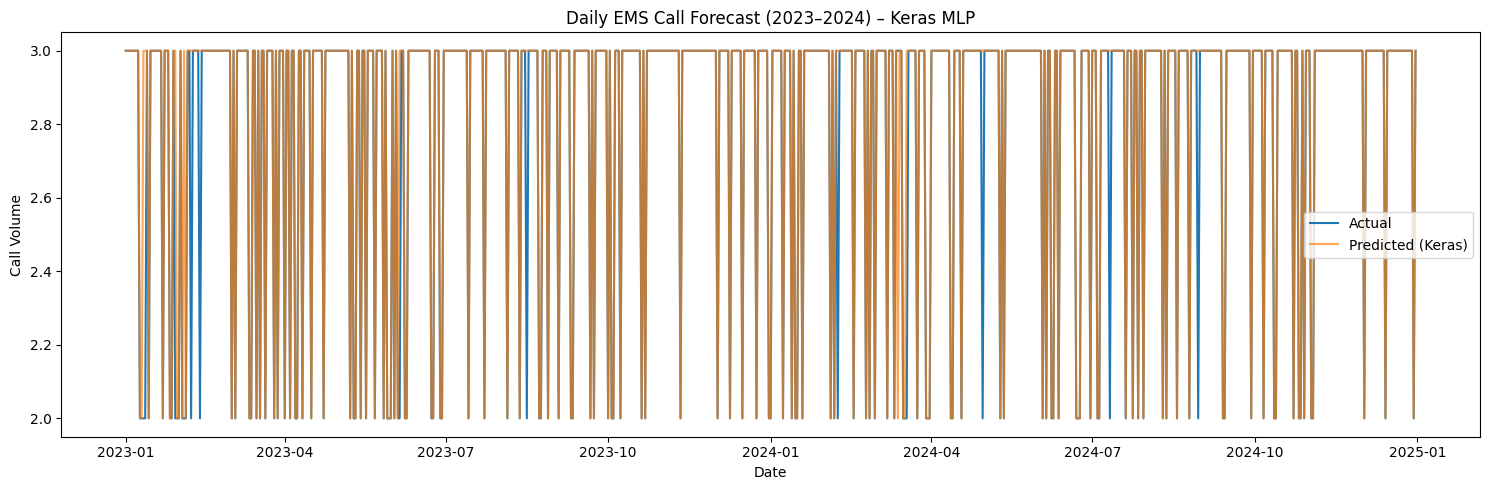

In [8]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# --- Scale Inputs ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Log-transform the target
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# --- Build Keras Model ---
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(1)  # Output layer (regression)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

# --- Callbacks ---
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# --- Train ---
history = model.fit(
    X_train_scaled, y_train_log,
    validation_split=0.1,
    epochs=300,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# --- Predict & Evaluate ---
preds_log = model.predict(X_test_scaled).flatten()
preds = np.expm1(preds_log).round().astype(int)
y_test_actual = np.expm1(y_test_log).round().astype(int)

rmse = np.sqrt(mean_squared_error(y_test_actual, preds))
print(f"Keras MLP RMSE: {rmse:.2f}")

# --- Plot ---
plt.figure(figsize=(15, 5))
plt.plot(test['date'], y_test_actual, label='Actual')
plt.plot(test['date'], preds, label='Predicted (Keras)', alpha=0.7)
plt.legend()
plt.title('Daily EMS Call Forecast (2023–2024) – Keras MLP')
plt.xlabel('Date')
plt.ylabel('Call Volume')
plt.tight_layout()
plt.show()


Epoch 1/300


/Users/sebastiancondyles/IdeaProjects/AdvAlgoHW4_1/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7417 - root_mean_squared_error: 0.8569 - val_loss: 0.9374 - val_root_mean_squared_error: 0.9682
Epoch 2/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3147 - root_mean_squared_error: 0.5608 - val_loss: 0.4800 - val_root_mean_squared_error: 0.6928
Epoch 3/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2269 - root_mean_squared_error: 0.4762 - val_loss: 0.2432 - val_root_mean_squared_error: 0.4931
Epoch 4/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1652 - root_mean_squared_error: 0.4063 - val_loss: 0.1414 - val_root_mean_squared_error: 0.3761
Epoch 5/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1384 - root_mean_squared_error: 0.3718 - val_loss: 0.1076 - val_root_mean_squared_error: 0.3280
Epoch 6/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1214 - root_mean_squared_error: 0.3483 - val_loss: 0.0602 - val_root_mean_squared_error: 0.2454
Epoch 7/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1075 - ro

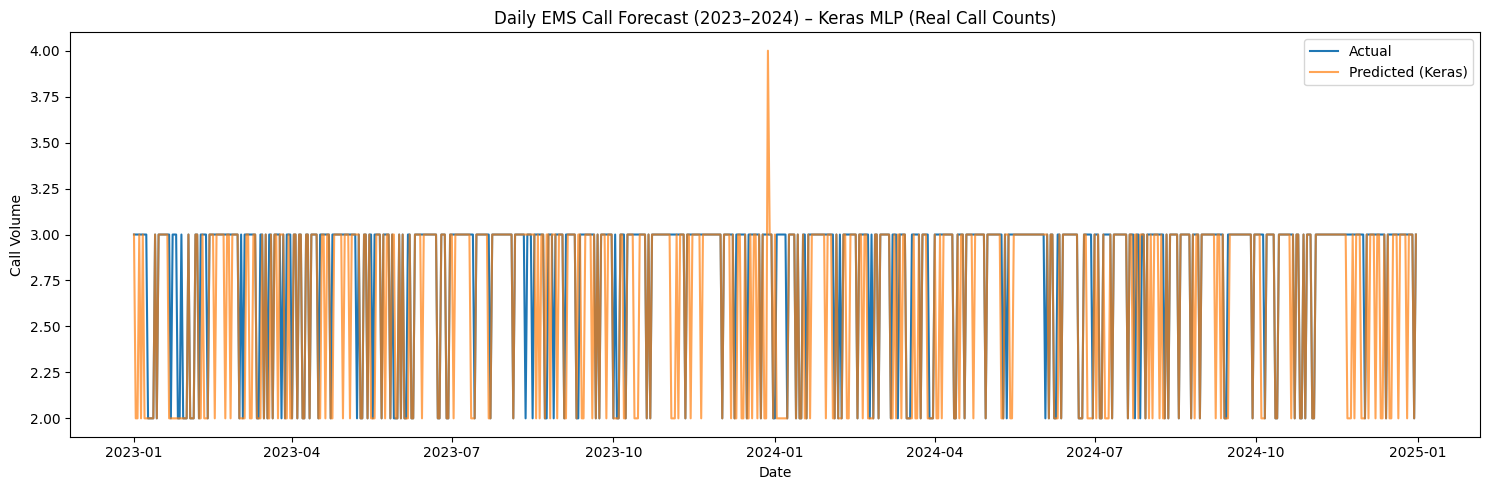

In [9]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# --- 1. Scale Features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 2. Log-transform targets for training (but output will be real counts) ---
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)  # used only for RMSE computation

# --- 3. Build Keras MLP Model ---
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(1)  # Output layer
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='mse',  # still training on log targets
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

# --- 4. Training with Early Stopping ---
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train_log,
    validation_split=0.1,
    epochs=300,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# --- 5. Predict and Convert Back to Real Counts ---
preds_log = model.predict(X_test_scaled).flatten()
preds = np.expm1(preds_log).round().astype(int)  # real-world predictions
y_test_actual = y_test.round().astype(int)       # true call counts

# --- 6. RMSE on actual call volume scale ---
rmse = np.sqrt(mean_squared_error(y_test_actual, preds))
print(f"Keras MLP RMSE (actual calls): {rmse:.2f}")

# --- 7. Plot Actual vs Predicted Calls ---
plt.figure(figsize=(15, 5))
plt.plot(test['date'], y_test_actual, label='Actual')
plt.plot(test['date'], preds, label='Predicted (Keras)', alpha=0.7)
plt.legend()
plt.title('Daily EMS Call Forecast (2023–2024) – Keras MLP (Real Call Counts)')
plt.xlabel('Date')
plt.ylabel('Call Volume')
plt.tight_layout()
plt.show()


Epoch 1/300


/Users/sebastiancondyles/IdeaProjects/AdvAlgoHW4_1/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.4579 - root_mean_squared_error: 1.1919 - val_loss: 0.5892 - val_root_mean_squared_error: 0.7676
Epoch 2/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4395 - root_mean_squared_error: 0.6626 - val_loss: 0.2358 - val_root_mean_squared_error: 0.4856
Epoch 3/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3420 - root_mean_squared_error: 0.5831 - val_loss: 0.1109 - val_root_mean_squared_error: 0.3330
Epoch 4/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2437 - root_mean_squared_error: 0.4933 - val_loss: 0.0610 - val_root_mean_squared_error: 0.2469
Epoch 5/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2000 - root_mean_squared_error: 0.4469 - val_loss: 0.0373 - val_root_mean_squared_error: 0.1933
Epoch 6/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1901 - root_mean_squared_error: 0.4352 - val_loss: 0.0452 - val_root_mean_squared_error: 0.2126
Epoch 7/300
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1551 - ro

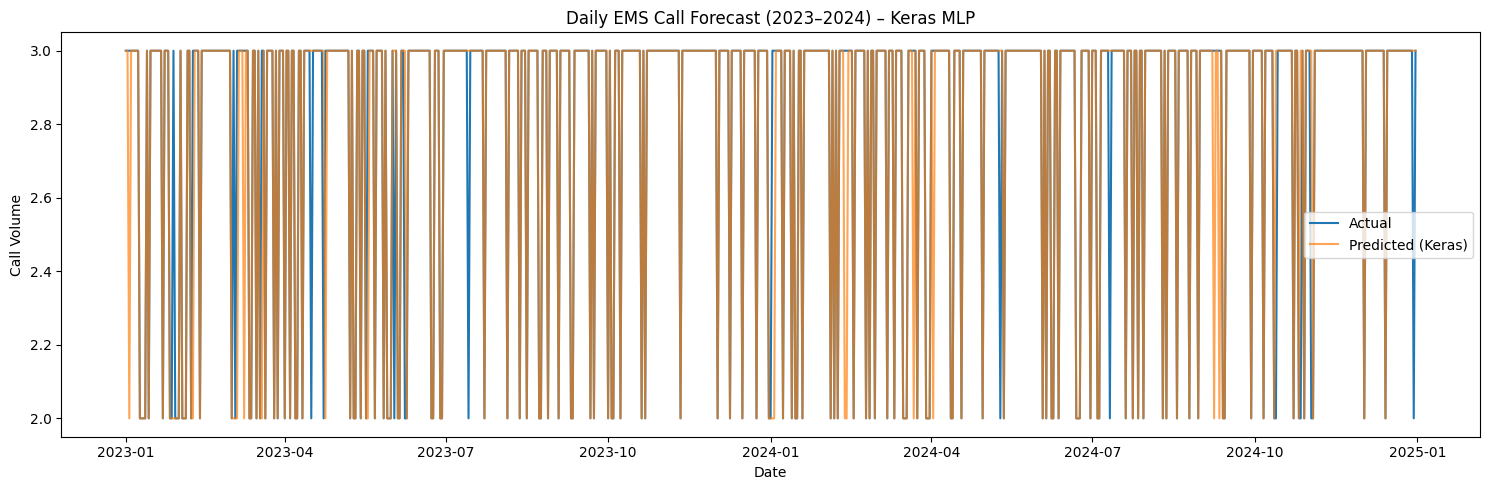


First 10 Predictions:


AttributeError: 'numpy.datetime64' object has no attribute 'date'

In [10]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# --- 1. Scale Features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 2. Log-transform targets for training only ---
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# --- 3. Build Keras Model ---
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(1)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

# --- 4. Early stopping ---
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# --- 5. Train ---
history = model.fit(
    X_train_scaled, y_train_log,
    validation_split=0.1,
    epochs=300,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# --- 6. Predict and Convert to Actual Call Counts ---
preds_log = model.predict(X_test_scaled).flatten()
preds = np.expm1(preds_log).round().astype(int)
y_test_actual = y_test.round().astype(int)

# --- 7. Evaluate ---
rmse = np.sqrt(mean_squared_error(y_test_actual, preds))
print(f"Keras MLP RMSE (actual call counts): {rmse:.2f}")

# --- 8. Plot Actual vs Predicted (REAL call counts) ---
plt.figure(figsize=(15, 5))
plt.plot(test['date'], y_test_actual, label='Actual')
plt.plot(test['date'], preds, label='Predicted (Keras)', alpha=0.7)
plt.legend()
plt.title('Daily EMS Call Forecast (2023–2024) – Keras MLP')
plt.xlabel('Date')
plt.ylabel('Call Volume')
plt.tight_layout()
plt.show()

# --- 9. Print Sample Day-by-Day Comparisons ---
print("\nFirst 10 Predictions:")
for d, actual, pred in zip(test['date'].values[:10], y_test_actual[:10], preds[:10]):
    print(f"{d.date()}: Actual = {actual}, Predicted = {pred}")
